<a href="https://colab.research.google.com/github/cyp-ark/semisupervisedlearning/blob/main/pi_model_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import np_utils
from keras.datasets import cifar10

import keras.backend as K

In [2]:
img_input = keras.Input(shape=(32,32,3))
aug_input = layers.GaussianNoise(stddev = 0.15)(img_input)

In [18]:
x1 = layers.Conv2D(128,(3,3),padding="same")(aug_input)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.Conv2D(128,(3,3),padding="same")(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.Conv2D(128,(3,3),padding="same")(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)

x1 = layers.MaxPool2D((2,2))(x1)
x1 = layers.Dropout(rate=0.5,seed = 13)(x1)

x1 = layers.Conv2D(256,(3,3),padding="same")(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.Conv2D(256,(3,3),padding="same")(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.Conv2D(256,(3,3),padding="same")(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)

x1 = layers.MaxPool2D((2,2))(x1)
x1 = layers.Dropout(rate=0.5,seed = 57)(x1)

x1 = layers.Conv2D(512,(3,3),padding="valid")(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.Conv2D(256,(1,1))(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.Conv2D(128,(1,1))(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)

x1 = layers.GlobalAveragePooling2D()(x1)
output1 = layers.Dense(10, activation = "Softmax",name="z")(x1)
#output1_1 = layers.Dense(10, activation = "Softmax")(x1)

In [19]:
x2 = layers.Conv2D(128,(3,3),padding="same")(aug_input)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.Conv2D(128,(3,3),padding="same")(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.Conv2D(128,(3,3),padding="same")(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)

x2 = layers.MaxPool2D((2,2))(x2)
x2 = layers.Dropout(rate=0.5,seed = 24)(x2)

x2 = layers.Conv2D(256,(3,3),padding="same")(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.Conv2D(256,(3,3),padding="same")(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.Conv2D(256,(3,3),padding="same")(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)

x2 = layers.MaxPool2D((2,2))(x2)
x2 = layers.Dropout(rate=0.5,seed = 68)(x2)

x2 = layers.Conv2D(512,(3,3),padding="valid")(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.Conv2D(256,(1,1))(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.Conv2D(128,(1,1))(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)

x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(10, activation = "Softmax")(x2)

output2 = layers.subtract([x2,output1],name="z_hat")

In [20]:
model = keras.Model(inputs=img_input, outputs = [output1, output2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 32, 32, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 128)  3584        ['gaussian_noise[0][0]']         
                                                                                                  
 conv2d_27 (Conv2D)             (None, 32, 32, 128)  3584        ['gaussian_noise[0][0]']         
                                                                                            

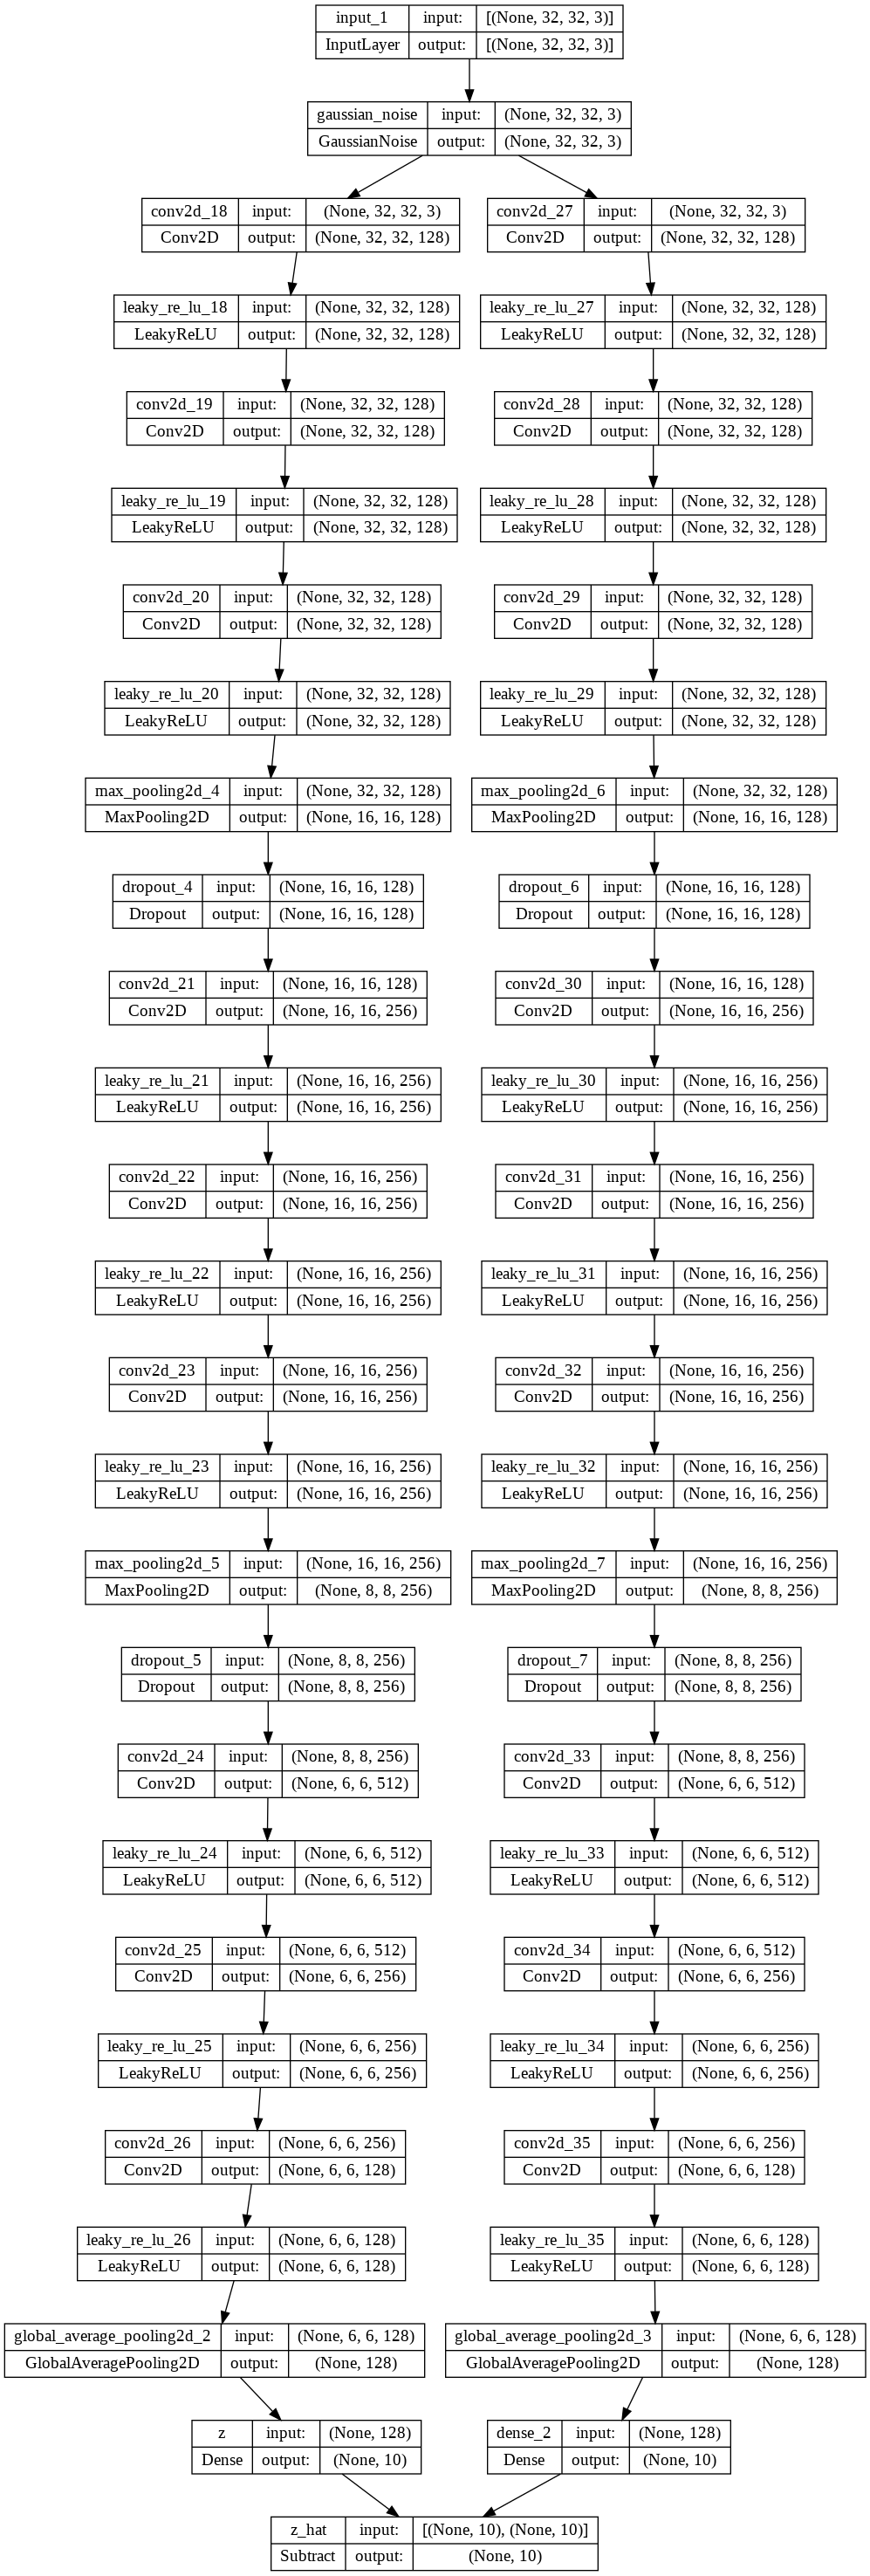

In [21]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [32]:
from tensorflow.keras import losses

#def pi_model_loss(y_true,y_pred):
  #const = K.cast(K.not_equal(K.sum(y_true),0),"float32")
  #return (1 - const) * (-1) * K.dot( K.log(K.exp(y_pred) / K.sum(K.exp(y_pred) )), K.transpose(y_true) )


def pi_model_loss(y_true,y_pred):
  return (-1) * K.dot( K.log(K.exp(y_pred) / K.sum(K.exp(y_pred) )), K.transpose(y_true) )



In [49]:
class Dynamic_loss_weights(tf.keras.callbacks.Callback):
  def __init__(self,w1,w2):
    self.w1 = w1
    self.w2 = w2
  def on_epoch_end(self,epoch,logs={}):
    self.w2 = 1 - 0.999^epoch

Dynamic_loss = Dynamic_loss_weights(1,0.001)

In [8]:
(X_train, y_train), (X_test,y_test) = cifar10.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.003),
    loss=[pi_model_loss, keras.losses.mse],
    loss_weights=Dynamic_loss,
    metrics = ['accuracy']
)

history = model.fit(X_train, y_train, batch_size=300, epochs=3)

test_scores = model.evaluate(X_test,y_test,verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

In [17]:
test_scores

[4.680620193481445,
 5.825771331787109,
 0.10000026226043701,
 0.10000000149011612,
 0.10000000149011612]

In [9]:
import random
idx_0 = random.sample(range(50000),45000)

In [10]:
y_train[idx_0] = [0,0,0,0,0,0,0,0,0,0]
y_train = y_train.astype("float32")

In [19]:
a = tf.Variable([[0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]])
b = tf.Variable([[0,0.0,0,0,0,0,0,0,0,0]])

K.print_tensor(

(-1) * K.dot(K.log(K.exp(a) / K.sum(K.exp(a))), K.transpose(b))

)

 [[-0]]


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.]], dtype=float32)>

In [ ]:
a = tf.Variable([[0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]])
b = tf.Variable([[0,1.0,0,0,0,0,0,0,0,0]])

K.print_tensor(

K.dot(a,K.transpose(b))

)

 [[0.805]]


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.805]], dtype=float32)>

In [17]:
y_train.sum()

5000.0

In [24]:
X_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]